In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 31.6 MB/s 
     |████████████████████████████████| 9.9 MB 47.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import pandas as pd
import numpy as np
import datetime

In [3]:
url = 'https://raw.githubusercontent.com/Pollutants/Datasets/main/Jul_2017-Nov-2022_8hrs_PollutionData.csv'
df = pd.read_csv(url, engine='python', parse_dates=True)

In [4]:
del df['To Date']
df

,From Date,PM2.5
0,01-07-2017 00:00,28.30
1,01-07-2017 08:00,31.23
2,01-07-2017 16:00,45.17
3,02-07-2017 00:00,34.57
4,02-07-2017 08:00,40.26
...,...,...
5871,09-11-2022 00:00,52.03
5872,09-11-2022 08:00,55.35
5873,09-11-2022 16:00,60.77
5874,10-11-2022 00:00,76.84


In [5]:

upper_limit = df['PM2.5'].quantile(0.95)
lower_limit = df['PM2.5'].quantile(0.01)

In [7]:
df 

,From Date,PM2.5
0,01-07-2017 00:00,28.30
1,01-07-2017 08:00,31.23
2,01-07-2017 16:00,45.17
3,02-07-2017 00:00,34.57
4,02-07-2017 08:00,40.26
...,...,...
5871,09-11-2022 00:00,52.03
5872,09-11-2022 08:00,55.35
5873,09-11-2022 16:00,60.77
5874,10-11-2022 00:00,76.84


In [8]:
df.index = pd.to_datetime(df['From Date'], format='%d-%m-%Y %H:%M')
df

,From Date,PM2.5
From Date,,
2017-07-01 00:00:00,01-07-2017 00:00,28.30
2017-07-01 08:00:00,01-07-2017 08:00,31.23
2017-07-01 16:00:00,01-07-2017 16:00,45.17
2017-07-02 00:00:00,02-07-2017 00:00,34.57
2017-07-02 08:00:00,02-07-2017 08:00,40.26
...,...,...
2022-11-09 00:00:00,09-11-2022 00:00,52.03
2022-11-09 08:00:00,09-11-2022 08:00,55.35
2022-11-09 16:00:00,09-11-2022 16:00,60.77


In [9]:
del df['From Date']

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
new_df = df[(df['PM2.5'] <= upper_limit) & (df['PM2.5'] >= lower_limit)]
new_df

,PM2.5
From Date,
2017-07-01 00:00:00,28.30
2017-07-01 08:00:00,31.23
2017-07-01 16:00:00,45.17
2017-07-02 00:00:00,34.57
2017-07-02 08:00:00,40.26
...,...
2022-11-09 00:00:00,52.03
2022-11-09 08:00:00,55.35
2022-11-09 16:00:00,60.77


In [12]:
sns.set()

In [ ]:
plt.ylabel('PM2.5')
plt.xlabel('From Date')
plt.xticks(rotation=45)

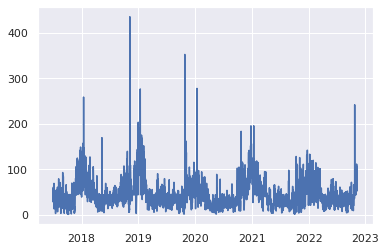

In [14]:
plt.plot(df.index, df['PM2.5'], )

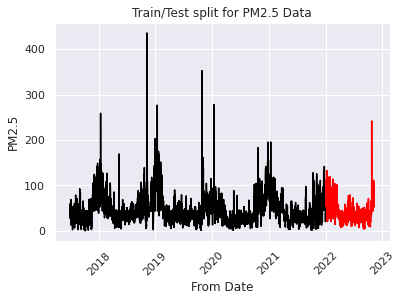

In [15]:
train = df[df.index < pd.to_datetime("01-01-2022 00:00", format='%d-%m-%Y %H:%M')]
test = df[df.index > pd.to_datetime("01-01-2022 00:00", format='%d-%m-%Y %H:%M')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('PM2.5')
plt.xlabel('From Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for PM2.5 Data")
plt.show()

ARMA

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [17]:
y = train['PM2.5']

In [18]:
ARMAmodel = SARIMAX(y, order = (3, 0, 4))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 8H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 8H will be used.
  self._init_dates(dates, freq)


In [19]:
ARMAmodel = ARMAmodel.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [20]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.01)
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

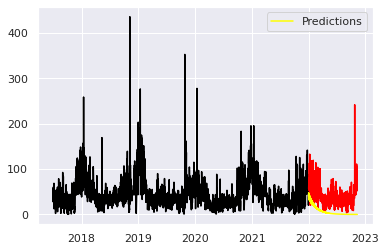

In [21]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out, color='Yellow', label = 'Predictions')
plt.legend()

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["PM2.5"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  39.60830863946145


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test["PM2.5"].values, y_pred_df["Predictions"])
mae

34.00934880229588

ARIMA

In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [25]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [26]:
adf_test(df['PM2.5'])

1. ADF :  -5.934120468357918
2. P-Value :  2.342811778217653e-07
3. Num Of Lags :  34
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 5841
5. Critical Values :
	 1% :  -3.431470043853999
	 5% :  -2.862034953954713
	 10% :  -2.5670334618919366


In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [27]:
stepwise_fit = auto_arima(df['PM2.5'], suppress_warnings=True, trace=True)           

stepwise_fit.summary()

NameError: ignored

In [28]:
ARIMAmodel = ARIMA(y, order = (3, 1, 4))
ARIMAmodel = ARIMAmodel.fit()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 8H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 8H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 8H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [29]:
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.01) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 


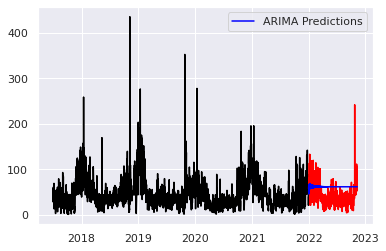

In [30]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out, color='Blue', label = 'ARIMA Predictions')
plt.legend()


In [31]:
arma_rmse = np.sqrt(mean_squared_error(test["PM2.5"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  31.038407194635933


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test["PM2.5"].values, y_pred_df["Predictions"])
mae

27.236501566206165

Sarima




In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

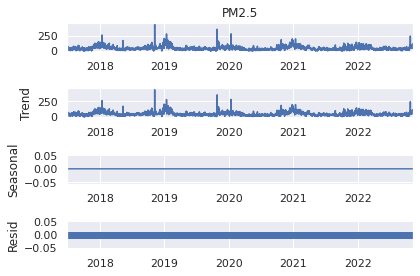

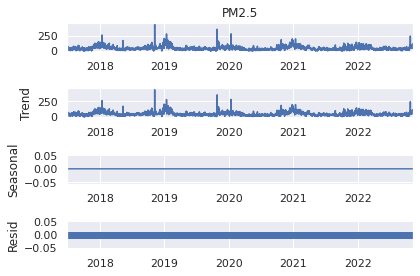

In [34]:
results=seasonal_decompose(df['PM2.5'],period=1)
results.plot()

In [35]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(df):
    dftest = adfuller(df)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [36]:
seasonal = results.seasonal
check_stationarity(seasonal)

The series is NOT stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


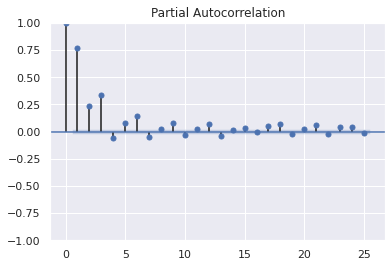

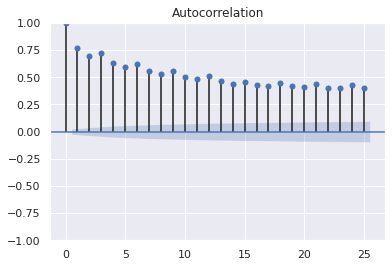

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
pacf = plot_pacf(df['PM2.5'], lags=25)
acf=plot_acf(df['PM2.5'], lags=25)

In [39]:
SARIMAXmodel = SARIMAX(y, order = (3, 1, 4), seasonal_order=(1,1,1,12))
SARIMAXmodel = SARIMAXmodel.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 8H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 8H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [40]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.01) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

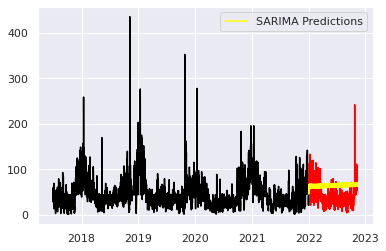

In [41]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out, color='Yellow', label = 'SARIMA Predictions')
plt.legend()

In [45]:

Sarima_rmse = np.sqrt(mean_squared_error(test["PM2.5"].values, y_pred_df["Predictions"]))
print("RMSE: ",Sarima_rmse)

RMSE:  33.05941508175754


In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test_results['Actuals'], test_results['Test Predictions'])
mae

NameError: ignored